## Re-calculate market access to compare added access from regional cities.
Use Mapbox API to calcuate travel time to major domestic and neighboring cities (population greater than 50k).  
Use district centroids as origins.  
Run market access calculation again.  

In [1]:
import os, sys, time, importlib, glob

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import rasterio as rio
from osgeo import gdal
import GOSTnets.calculate_od_raw as calcOD
import numpy as np

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator
from infrasap import mapbox_helper as mb

from shapely.wkt import loads
from dotenv import load_dotenv, find_dotenv

%load_ext autoreload
%autoreload 2

In [2]:
country = 'guatemala'
iso3 = 'GTM'
epsg = 26915

In [3]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
mb_token = os.environ.get("MB_TOKEN")

### Load data

In [4]:
base_in = "/home/public/Data/PROJECTS/INFRA_SAP"
in_folder = os.path.join(base_in, iso3)

# define data paths
focal_admin2 = os.path.join(in_folder, "admin.shp")
focal_osm = os.path.join(in_folder, f"{country}-latest.osm.pbf")
pop_name = "WP_2020_1km"
wp_1km = os.path.join(in_folder, f"{pop_name}.tif")
urban_extents = os.path.join(in_folder, "urban_extents.shp")
airports = os.path.join(in_folder, "airports.shp")
ports = os.path.join(in_folder, "ports.shp")
borders = os.path.join(in_folder, "borders.shp")
G_path = os.path.join(in_folder, 'graph', f"G_{iso3}.pickle")

base_out = "/home/wb514197/data/INFRA_SAP" # GOT permission denied using public 
out_folder = os.path.join(base_out, iso3)
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

global_cities = '/home/public/Data/PROJECTS/LAC_GOSTNets/Destinations/Cities_centroids_FINAL_pop.shp'
global_admin = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'
# global_cities = '/home/public/Data/GLOBAL/Population/Major_Cities.shp'
# global_cities = '/home/public/Data/GLOBAL/Population/global_settlement_points_v1_01_gt50000.shp'

In [5]:
target = gpd.read_file(focal_admin2)
target['centroid'] = target.centroid
cities = gpd.read_file(global_cities)
adm0 = gpd.read_file(global_admin)
adm0 = adm0.loc[adm0.is_valid]
cities = gpd.sjoin(cities, adm0[['ADM0_NAME','geometry']], how='left')

In [6]:
pop_thresh = 50000
dist_thresh = 100000 # meters
cities = cities[cities.Pop>pop_thresh].copy()

cities_proj = cities.to_crs(f'EPSG:{epsg}')
target_proj = target.to_crs(f'EPSG:{epsg}')

In [7]:
target_buffer = target_proj.buffer(dist_thresh)
cities_filter = cities_proj[cities_proj.intersects(target_buffer.unary_union)]

In [8]:
# Remove cities from the target country
cities_filter = cities_filter[cities_filter.ADM0_NAME!=country].copy()
cities_filter = cities_filter.to_crs(cities.crs)

In [9]:
cities_adm0 = gpd.read_file(urban_extents)
cities_adm0 = cities_adm0[cities_adm0.Pop>pop_thresh]
cities_adm0['geometry'] = cities_adm0.geometry.centroid

In [10]:
cities_concat = pd.concat([cities_filter, cities_adm0]).reset_index(drop=True)

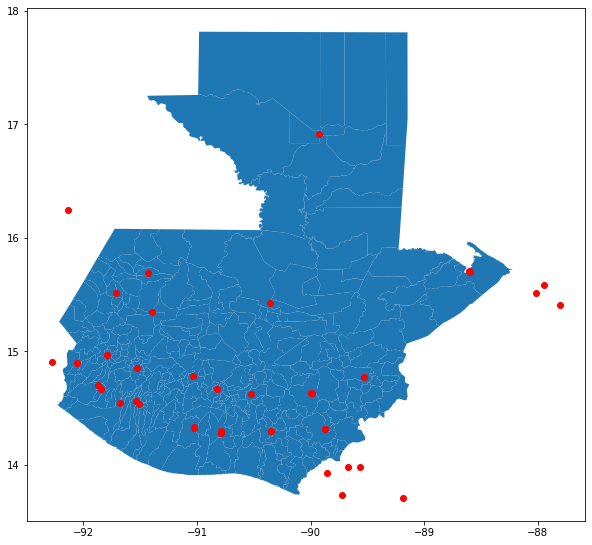

In [11]:
ax = target.plot(figsize=(10, 10))
cities_concat.plot(figsize=(10, 10), ax=ax, color='red')

In [12]:
origins = target.copy()
dests = cities_concat.copy().reset_index(drop=True)

In [13]:
origins['x'] = origins.centroid.x
origins['y'] = origins.centroid.y

dests['x'] = dests.geometry.x
dests['y'] = dests.geometry.y

origins['ID'] = origins.OBJECTID
dests['ID'] = dests.index

origins['Pop'] = 1

In [14]:
odRes = mb.CreateODMatrix(origins, dests, lat_name = 'y', lon_name = 'x', UID = 'ID', 
                    Pop = 'Pop', call_type = 'MB', rescue = 0, rescue_num = 0, MB_Toke = mb_token, 
                    sleepTime = 5, osrmHeader = '')


Chosen server: MB

Start time: Thu Aug  6 15:13:55 2020
source list: 335
sources list: 28
dest list: 37
dests list: 3

Estimated remaining calls to chosen server: 84

save points will occur every 3 calls

Call to OSRM server number: 1 of 84
Call to OSRM server number: 2 of 84
Call to OSRM server number: 3 of 84
Call to OSRM server number: 4 of 84
Call to OSRM server number: 5 of 84
Call to OSRM server number: 6 of 84
Call to OSRM server number: 7 of 84
Call to OSRM server number: 8 of 84
Call to OSRM server number: 9 of 84
Call to OSRM server number: 10 of 84
Call to OSRM server number: 11 of 84
Call to OSRM server number: 12 of 84
Call to OSRM server number: 13 of 84
Call to OSRM server number: 14 of 84
Call to OSRM server number: 15 of 84
Call to OSRM server number: 16 of 84
Call to OSRM server number: 17 of 84
Call to OSRM server number: 18 of 84
Call to OSRM server number: 19 of 84
Call to OSRM server number: 20 of 84
Call to OSRM server number: 21 of 84
Call to OSRM server number

In [16]:
odRes['O_UID'] = odRes['O_UID'].astype('int')
odRes['D_UID'] = odRes['D_UID'].astype('int')

In [17]:
OD_re = odRes.pivot(index='O_UID', columns='D_UID', values='DIST')

In [18]:
OD_re.head()

D_UID,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
O_UID,,,,,,,,,,,,,,,,,,,,,
15740,16375.4,14535.2,10385.7,11576.0,12612.1,6355.5,7968.5,12676.8,14519.0,12331.4,...,22041.3,14534.9,12360.4,17310.4,15187.3,10179.4,5316.5,8104.0,9481.6,6195.2
15741,14177.8,12337.6,8188.1,9378.4,10414.5,5142.0,6755.0,11463.3,13305.5,12279.6,...,20827.8,12337.3,11505.7,16096.9,13973.8,10040.1,3118.9,6890.5,7284.0,4981.7
15742,17212.7,15372.5,11223.0,12413.3,13449.4,8176.9,9789.9,14498.2,16340.4,13789.3,...,23862.7,15372.2,13818.3,19131.8,17008.7,13287.7,6153.8,9925.4,10318.9,8016.6
15743,19560.3,17720.1,13570.6,14760.9,15797.0,9344.5,10957.5,15665.8,17508.0,9235.1,...,25030.3,11378.3,9264.1,20299.4,18176.3,12691.7,8501.4,11093.0,12666.5,9184.2
15744,18975.6,17135.4,12985.9,14176.2,15212.3,9939.8,11552.8,16261.1,18103.3,9252.6,...,25625.6,11395.8,9281.6,20894.7,18771.6,13766.4,7916.7,11688.3,12081.8,9779.5


In [19]:
dests.Pop[OD_re.columns]

D_UID
0     6.782830e+05
1     9.314000e+04
2     5.796400e+04
3     5.074700e+04
4     1.260720e+05
5     6.815600e+04
6     5.834900e+04
7     5.629000e+04
8     6.503300e+04
9     6.847100e+04
10    5.581000e+04
11    9.138900e+05
12    6.923800e+04
13    6.937200e+04
14    5.530900e+04
15    8.228800e+04
16    3.215490e+05
17    1.206910e+05
18    5.232000e+04
19    7.207200e+04
20    1.289060e+05
21    9.448638e+04
22    5.846745e+04
23    6.639780e+04
24    9.553302e+04
25    3.438983e+05
26    1.403887e+05
27    2.485858e+05
28    6.915896e+04
29    6.833316e+04
30    1.386588e+05
31    5.970781e+05
32    6.370814e+06
33    5.657606e+04
34    1.055554e+05
35    7.799138e+04
36    1.019955e+05
Name: Pop, dtype: float64

In [20]:
access_regional = calcOD.calculate_gravity(np.array(OD_re), dWeight = dests.Pop[OD_re.columns])

In [21]:
# access_domestic = calcOD.calculate_gravity(np.array(OD_re.loc[:,1:]), dWeight = dests.Pop[OD_re.loc[:,1:].columns])
# if adm0 name is null, then it's a domestic city
access_domestic = calcOD.calculate_gravity(np.array(OD_re.loc[:,dests.loc[dests.ADM0_NAME.isnull()].index]), 
                                           dWeight = dests.Pop[dests.loc[dests.ADM0_NAME.isnull()].index])

In [22]:
access_regional = access_regional.rename(columns = {
        'd_0.01': 'ma_reg_1',
        'd_0.005': 'ma_reg_2',
        'd_0.001' : 'ma_reg_3',
        'd_0.0007701635' : 'ma_reg_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'ma_reg_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'ma_reg_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'ma_reg_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'ma_reg_8',   # Market access halves every 300 mins
        'd_1e-05' : 'ma_reg_9'
    })

access_domestic = access_domestic.rename(columns = {
        'd_0.01': 'ma_dom_1',
        'd_0.005': 'ma_dom_2',
        'd_0.001' : 'ma_dom_3',
        'd_0.0007701635' : 'ma_dom_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'ma_dom_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'ma_dom_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'ma_dom_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'ma_dom_8',   # Market access halves every 300 mins
        'd_1e-05' : 'ma_dom_9'
    })

In [23]:
access_pch = pd.DataFrame((access_regional.values-access_domestic.values)/access_domestic.values,
             index = access_regional.index,
             columns=['ma_pch_1', 'ma_pch_2', 'ma_pch_3', 'ma_pch_4',
                      'ma_pch_5', 'ma_pch_6', 'ma_pch_7', 'ma_pch_8', 'ma_pch_9'])

In [24]:
access_pdif = pd.DataFrame((access_regional.values-access_domestic.values)/((access_regional.values+access_domestic.values)/2),
             index = access_regional.index,
             columns=['ma_pdif_1', 'ma_pdif_2', 'ma_pdif_3', 'ma_pdif_4',
                      'ma_pdif_5', 'ma_pdif_6', 'ma_pdif_7', 'ma_pdif_8', 'ma_pdif_9'])

In [25]:
access_join = access_domestic.loc[:,'ma_dom_5':].join(access_regional.loc[:,'ma_reg_5':]).join(access_pch.loc[:,'ma_pch_5':]).join(access_pdif.loc[:,'ma_pdif_5':])
access_join['OBJECTID'] = OD_re.index
newdf = target.merge(access_join, on='OBJECTID')
newdf.drop(['geometry','Shape_Leng','Shape_Area'], axis=1, inplace=True)

In [26]:
output_path = os.path.join(out_folder, 'tables')
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [27]:
newdf.to_excel(os.path.join(output_path, "11Regional Analysis.xlsx"), index=False)